In [1]:
import os
import math
import random
import numpy as np
import pandas as pd
import tensorflow as tf
import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping,ReduceLROnPlateau
from keras.models import Sequential
from keras.layers import Dense,Flatten,MaxPooling2D,Conv2D,Dropout,Activation,BatchNormalization
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import Image, display
from sklearn.cluster import KMeans
from sklearn.utils import shuffle
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import train_test_split, GridSearchCV, HalvingGridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA,NMF, FactorAnalysis

In [2]:
arabic_chars =list('ابتثجحخدذرزسشصضطظعغفقكلمنهوي')
arabic_chars

['ا',
 'ب',
 'ت',
 'ث',
 'ج',
 'ح',
 'خ',
 'د',
 'ذ',
 'ر',
 'ز',
 'س',
 'ش',
 'ص',
 'ض',
 'ط',
 'ظ',
 'ع',
 'غ',
 'ف',
 'ق',
 'ك',
 'ل',
 'م',
 'ن',
 'ه',
 'و',
 'ي']

In [3]:
x_train = pd.read_csv("/content/csvTrainImages 13440x1024.csv",header=None).to_numpy()
y_train = pd.read_csv("/content/csvTrainLabel 13440x1.csv",header=None).to_numpy()-1 

x_test = pd.read_csv("/content/csvTestImages 3360x1024.csv",header=None).to_numpy()
y_test = pd.read_csv("/content/csvTestLabel 3360x1.csv",header=None).to_numpy()-1

print("x_train.shape =", x_train.shape)
print("y_train.shape =", y_train.shape)
print("x_test.shape =", x_test.shape)
print("y_test.shape =", y_test.shape)

x_train.shape = (13440, 1024)
y_train.shape = (13440, 1)
x_test.shape = (3360, 1024)
y_test.shape = (3360, 1)


In [4]:
x_train = x_train.reshape(-1,32,32)
x_test = x_test.reshape(-1,32,32)
x_train = x_train/255
x_test = x_test/255
# for some reason the images are flipped and rotated
# so we transpose each image to be in the correct shape
x_train = np.array([image.T for image in x_train])
x_test = np.array([image.T for image in x_test])

# shuffle
x_train, y_train = shuffle(x_train, y_train)
x_test, y_test = shuffle(x_test, y_test)

print(x_train.shape, x_test.shape)

(13440, 32, 32) (3360, 32, 32)


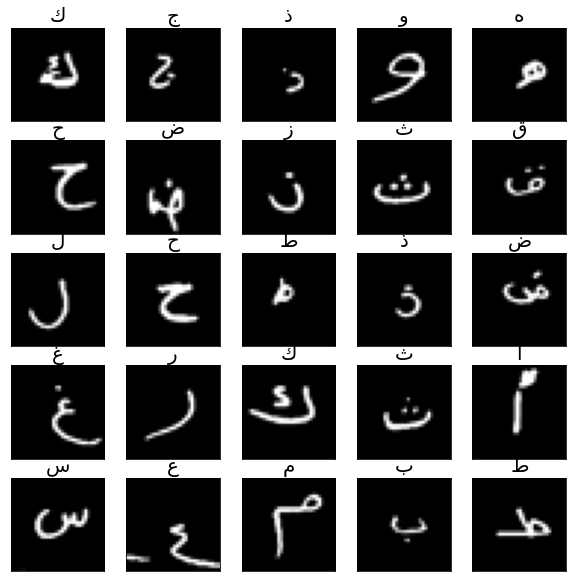

In [5]:
ra = np.random.randint(0, 13440, size=25)
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(x_train[ra[i]].reshape(32,32),"gray")
    plt.title(arabic_chars[int(y_train[ra[i]][0])], fontsize = 20)
plt.show()

In [6]:
from keras.utils.np_utils import to_categorical
y_train = y_train.reshape(-1)
y_test = y_test.reshape(-1)

y_train_h = to_categorical(y_train)
y_test_h = to_categorical(y_test)

print(y_train.shape, y_test.shape)
print(y_train_h.shape, y_test_h.shape)

(13440,) (3360,)
(13440, 28) (3360, 28)


In [7]:
x_train = x_train.reshape(-1,32,32, 1)
x_test = x_test.reshape(-1,32,32, 1)

train_datagen=ImageDataGenerator(
    #rescale=1/255, # Normalize the new images
    zoom_range=0.2, #the amount of zooming u need
    width_shift_range=0.10, # The percentage of Width shifitning
    height_shift_range=0.10, # The percentage of height shifitning
    shear_range=0.1, #Shear angle in counter-clockwise direction in degrees
    fill_mode='nearest',
    rotation_range=20, 
)
train_generator=train_datagen.flow(
    x_train ,y_train ,batch_size=64
)

test_datagen=ImageDataGenerator()
test_generator=test_datagen.flow(
    x_test ,y_test ,batch_size=64
 
)

In [8]:
earlystop = EarlyStopping(patience=6)
learning_rate_reduction=ReduceLROnPlateau(
    monitor='val_acc',
    patience= 3,
    verbose=1,
)
callbacks = [earlystop, learning_rate_reduction]

In [9]:
model=Sequential() 

model.add(Conv2D(80,(5,5),activation='relu',input_shape=(32,32,1)))
model.add(MaxPooling2D(2,2))
model.add(Conv2D(64,(5,5),activation='relu'))
model.add(MaxPooling2D(2,2))
model.add(Flatten())
model.add(Dense(1024,activation='relu', name='featurs'))
#model.add(Dropout(0.5))
model.add(Dense(28, kernel_regularizer=keras.regularizers.l2(0.01) ,activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 80)        2080      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 80)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 10, 10, 64)        128064    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 5, 5, 64)         0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 1600)              0         
                                                                 
 featurs (Dense)             (None, 1024)              1

In [10]:
model.compile(optimizer= 'adam' ,loss='sparse_categorical_crossentropy',metrics=['accuracy'])
model.fit(
    train_generator, 
    epochs=50,
    validation_data=test_generator,
    callbacks=callbacks
)

Epoch 1/50
210/210 [==============================] - 16s 23ms/step - loss: 1.9908 - accuracy: 0.4430 - val_loss: 0.8253 - val_accuracy: 0.7729 - lr: 0.0010
Epoch 2/50
210/210 [==============================] - 5s 22ms/step - loss: 0.9944 - accuracy: 0.7193 - val_loss: 0.5861 - val_accuracy: 0.8408 - lr: 0.0010
Epoch 3/50
210/210 [==============================] - 5s 22ms/step - loss: 0.7795 - accuracy: 0.7827 - val_loss: 0.5135 - val_accuracy: 0.8491 - lr: 0.0010
Epoch 4/50
210/210 [==============================] - 5s 22ms/step - loss: 0.6734 - accuracy: 0.8078 - val_loss: 0.4087 - val_accuracy: 0.8982 - lr: 0.0010
Epoch 5/50
210/210 [==============================] - 5s 22ms/step - loss: 0.6067 - accuracy: 0.8284 - val_loss: 0.3934 - val_accuracy: 0.9104 - lr: 0.0010
Epoch 6/50
210/210 [==============================] - 5s 22ms/step - loss: 0.5596 - accuracy: 0.8456 - val_loss: 0.3195 - val_accuracy: 0.9256 - lr: 0.0010
Epoch 7/50
210/210 [==============================] - 5s 22ms/s

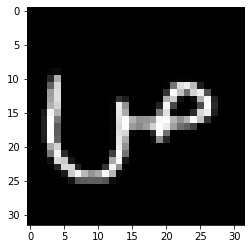

In [12]:
plt.imshow(x_test[17].reshape(32,32),"gray")
plt.show()




# pred = model.predict(x_test)
# print(pred.shape)
# np.argmax(pred[2])
# #print(pred)

In [14]:
from keras_preprocessing.image import load_img,img_to_array

In [19]:


img=load_img("/content/image2.jpeg",grayscale=True,target_size=(32,32))
img=img_to_array(img)
img=img.reshape(1,32,32,1)


pred = model.predict(img)
print(pred.shape)
np.argmax(pred[0])
#print(pred)

(1, 28)


/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/utils.py:107: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '


0

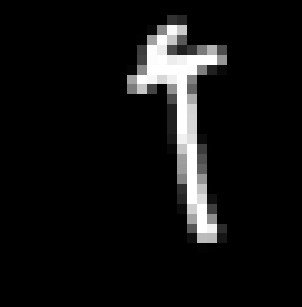

In [18]:
Image("/content/image2.jpeg")